<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP7%20-%20Dimensionality%20Reduction/MP_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de Máquina - TP7: Encuestas de salud y trabajo

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
dataroot = "https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/3_MidtermProjects/trabajadores/ecetss_ocupados.csv"
df = pd.read_csv(dataroot)
df.head()

,codmuestra,hogar,region,ponderaocup,C0P10.2,C0P10.3,C3P16.1,C3P16.2,nivel_ed,C3P16.6,C3P16.6.1cod,C3P16.7,C3P16.8,C1P2.1,C1P2.6,cat_ocup,rama_caes,ocupa_cno,ramacaes_o,sector,establecimiento,sit_oc,tamanio,antigestab_a,antigpuesto,registracion,upreg,tickets,quien_contrato,C1P3.1.10,C1P3.1.11,C1P3.1.12,C1P3.1.15,C1P3.1.16,C1P3.2.10,C1P3.2.11,C1P3.2.12,C1P3.3.1,C1P3.3.2,antigestab_sd,...,C2P12.15,C1P3.3.14,C1P3.3.19,aumentosal,C2P12.11,C1P3.3.18,ingreso_op,C2P13.1.1,C2P13.1.2,C2P13.1.3,C2P13.1.4,C2P13.1.5,C2P13.1.6,C2P13.1.7,C2P13.1.8,C2P13.1.9,C2P13.1.10,C2P13.4.2,C2P13.4.3,C2P13.4.4,C2P13.4.5,C2BP13.2,C2BP13.3,C3P14.2,C3P14.3,C3P14.4,C3P14.5,C3P14.6,C3P14.7,C3P14.8,trabdom_noremu,C3P15.1,C3P15.2,C3P15.3,C3P17.1,edadhogar,pershog_ag,edad_0a5,edad_6a11,edad_12a17
0,002-0001-0009,1,10,7376.238659,1,75,1,2,10,1,NaN,NaN,1,1,1,3,8501,41311,9,2,6.0,2,99.0,25.00,0.97,2.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,7000,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03:00,1,5,11,1,2,1,1,1
1,002-0001-0012,1,10,7376.238659,2,57,1,2,4,1,NaN,NaN,1,1,1,1,4803,5002,4,2,1.0,5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,00:00,1,1,99,6,2,1,1,1
2,002-0001-0013,1,10,3688.119329,1,38,2,1,8,1,NaN,NaN,1,2,1,3,6500,10313,7,1,NaN,1,9.0,3.00,3.00,1.0,4.0,1.0,1.0,1.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,32000,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,NaN,NaN,NaN,-99.0,1,01:30,1,5,7,2,2,1,2,1
3,002-0001-0015,1,10,3688.119329,1,37,2,1,10,2,210.0,2015.0,3,2,1,3,8600,40311,10,2,2.0,2,4.0,0.04,0.04,2.0,99.0,99.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,15000,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN,NaN,4000.0,1,03:00,3,4,3,6,1,1,1,1
4,002-0001-0017,1,10,3688.119329,1,46,2,2,6,1,NaN,NaN,1,1,1,3,8401,10333,8,1,NaN,1,99.0,8.00,0.08,1.0,4.0,99.0,1.0,3.0,4.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,-99,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,00:00,2,1,99,6,2,1,1,1


## Limpieza del dataset

En el dataset hay datos con valor `-99` o `99` que corresponden a casos donde el encuestado no sabe o no contesta.

Dada la gran cantidad de atributos y la dificultad que conlleva analizarlos individualmente para decidir un criterio para cada uno, resuelvo simplificar reemplazando todos los valores nulos por ceros.

In [37]:
# Reemplazo los valores NaN y los no 'sabe/no contesta' por ceros
df = df.drop(['codmuestra'], 1)
df.fillna(0, inplace=True)
df = df.replace(-99,0)
df = df.replace(99,0)
df = df.replace('-99','00:00') # en la columna C3P15.1 el -99 es un string

# Paso el tiempo de trabajo doméstico a float
time = df['C3P15.1'].str.split(':')   
hours, mins = time.str[0], time.str[1]  
df['C3P15.1'] = hours.astype(int) + (mins.astype(float) / 60)

## Análisis de los atributos: Desigualdad de género

### Diferencia en el ingreso

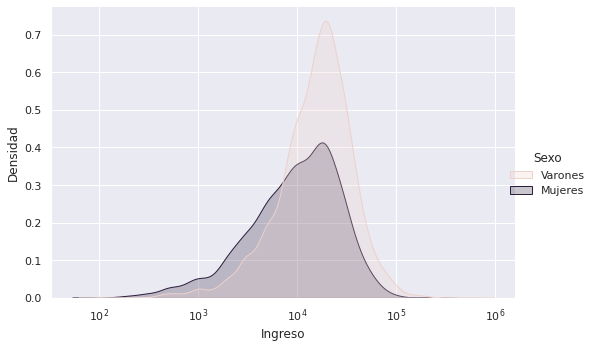

Media de ingresos mujeres: $12399 
Media de ingresos varones: $18279 
Diferencia: 47%


In [246]:
ingreso_df = df.loc[df.ingreso_op > 0, ['ingreso_op', 'C3P16.1']]
ingreso_df.loc[df.ingreso_op == 0, 'ingreso_op'] = 0.01

sns.set_theme()
g = sns.displot(ingreso_df,
            x="ingreso_op",
            hue="C3P16.1",
            kind="kde",
            log_scale=(True, False),
            fill=True,
            height=5,
            aspect=1.5)

g.set(xlabel='Ingreso', ylabel='Densidad')

g._legend.set_title('Sexo')
g._legend.texts[0].set_text('Varones')
g._legend.texts[1].set_text('Mujeres')

plt.show()

mean_1 = df.groupby('C3P16.1').mean()['ingreso_op'][1]
mean_2 = df.groupby('C3P16.1').mean()['ingreso_op'][2]
print('Media de ingresos mujeres: ' + '$' + str(int(mean_2)),
      '\nMedia de ingresos varones: ' + '$' + str(int(mean_1)),
      '\nDiferencia: ' + str(int((mean_1-mean_2)*100/mean_2)) + '%')

* Vemos que los ingresos de los varones son en promedio un 47% mayores que los de las mujeres.

### Horas dedicadas al trabajo doméstico

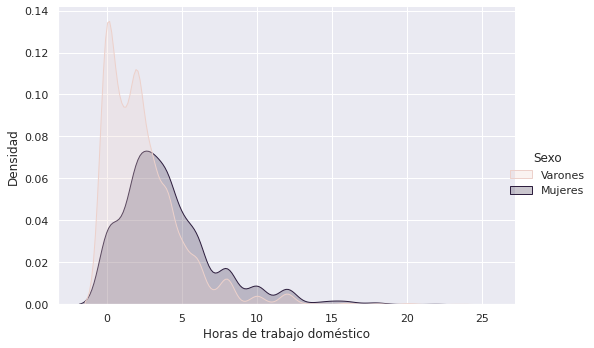

Media de horas varones:  2.4 
Media de horas mujeres:  4.0 
Diferencia: 66%


In [247]:
trab_domes_df = df.loc[df['C3P15.1'] >= 0, ['C3P15.1', 'C3P16.1']]

g = sns.displot(trab_domes_df,
            x="C3P15.1",
            hue="C3P16.1",
            kind="kde",
            log_scale=(False, False),
            fill=True,
            height=5,
            aspect=1.5)

g.set(xlabel='Horas de trabajo doméstico', ylabel='Densidad')

g._legend.set_title('Sexo')
g._legend.texts[0].set_text('Varones')
g._legend.texts[1].set_text('Mujeres')

plt.show()

mean_1 = df.groupby('C3P16.1').mean()['C3P15.1'][1]
mean_2 = df.groupby('C3P16.1').mean()['C3P15.1'][2]
print('Media de horas varones: ', '%.1f' % mean_1,
      '\nMedia de horas mujeres: ', '%.1f' % mean_2,
      '\nDiferencia: ' + str(int((mean_2-mean_1)*100/mean_1)) + '%')

* Vemos que las mujeres en promedio dedican un 66% más horas por día a tareas domésticas o de cuidado.

## Selección de atributos y clasificación por sexos

* La idea es ver qué variables son las más influyentes en la clasificación por sexos y ver si esto muestra las disparidades existentes

### Correlación entre atributos

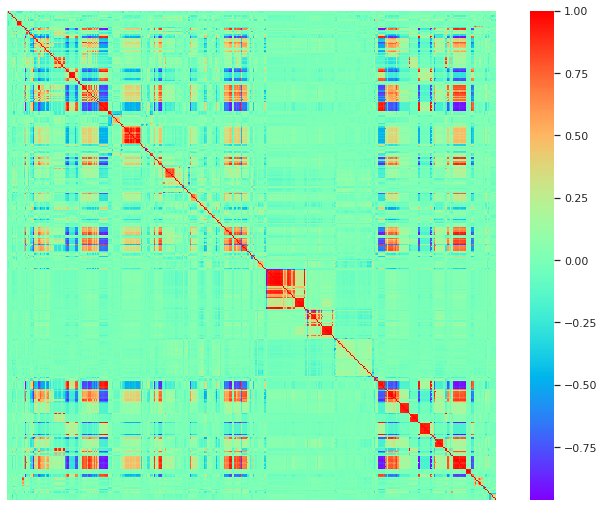

In [10]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), cmap='rainbow', annot=False, xticklabels=False, yticklabels=False, square=True)
plt.show()

* En la matriz de correlación podemos ver que la mayoría de los atributos están muy descorrelacionados (valores muy cercanos a cero), pero hay algunos con una correlación muy cercana a 1 o -1, con lo cual van a haber atributos redundantes.

### Voy a entrenar un clasificador utilizando como target el atributo `C3P16.1` (sexo de la persona encuestada). Para esto voy a utilizar dos métodos distintos para reducir la dimensionalidad:
* Selección basada en correlación entre atributos e información mutua con el target 
* Sequential Feature Selection

### 1 - Selección de atributos basada en la correlación entre atributos y la información mutua con el target (sexo)

In [73]:
from sklearn.feature_selection import mutual_info_classif as MIC

# Calculo la información mutua de todos los atributos con el target
X = df.drop('C3P16.1',1)
y = df['C3P16.1']
mi_scores = MIC(X,y)

'''Establezco un umbral de 0.85 en la correlación:
Cuando detecto dos atributos con una de correlación de 0.85 
o mayor, me quedo con el que tenga mayor información mutua con el target'''
data = X.copy()
corr = data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.85:
            if columns[j]:
                if mi_scores[i] > mi_scores[j]:
                    columns[j] = False
                elif mi_scores[i] < mi_scores[j]:
                    columns[i] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [72]:
#Cantidad de atributos luego de eliminar los redundantes
len(data.columns)

240

* El nuevo dataset tiene 240 atributos, lo que equivale al 65% de los atributos originales, una reducción significativa en la dimensionalidad del problema.

#### Vuelvo a graficar la matriz de correlación, pero sólo con los atributos seleccionados

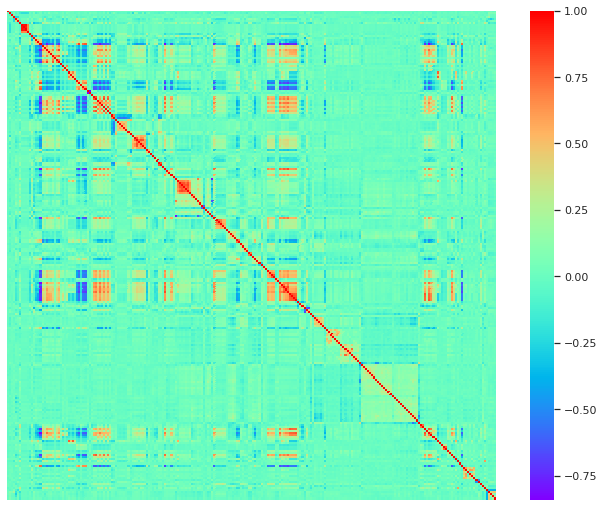

In [26]:
plt.figure(figsize=(12,9))
sns.heatmap(data.corr(), cmap='rainbow', annot=False, xticklabels=False, yticklabels=False, square=True)
plt.show()

* Vemos en la matriz de correlación que disminuyeron las regiones con valores muy cercanos a 1 y -1.

In [249]:
# Obtengo la información mutua de todos los atributos con el target
from sklearn.feature_selection import mutual_info_classif as MIC
X = data
y = df['C3P16.1']
mi_scores_new = mi_scores[columns]

#### Entreno un clasificador utilizando los 20 atributos que mayor información mutua tienen con el target

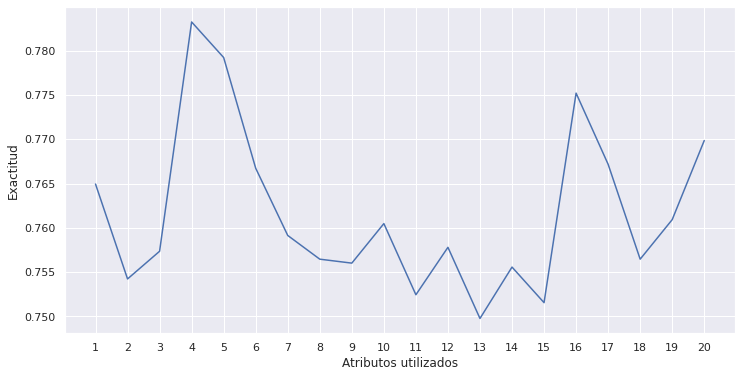

In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as TTS
from sklearn.tree import DecisionTreeClassifier as DTC

# Entreno el modelo para cada caso
n_features_limit = 20
features_vec = np.arange(n_features_limit)+1
scores_vec = []
for n_features in range(n_features_limit):
    indices = mi_scores_new.argsort()[-n_features:][::-1]
    mi_score_selected_index = mi_scores_new[indices]
    X_1 = X.iloc[:,indices]

    X_train,X_test,y_train,y_test = TTS(X_1,y,random_state=0,stratify=y)

    model = DTC().fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores_vec.append(score)

# Grafico la exactitud en función de la cantidad de atributos utilizados
sns.set()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=features_vec, y=scores_vec)
ax.set_xticks(features_vec)

ax.set(xlabel='Atributos utilizados', ylabel='Exactitud')

plt.show()

In [252]:
print('La máxima exactitud es de:', '%.3f' % scores_vec[3])

La máxima exactitud es de: 0.783


* Se ve que la mayor exactitud se logra utilizando los 4 primeros atributos, vamos a ver cuáles son estos.



In [85]:
mi_scores_df = pd.DataFrame({'MI score': mi_score_selected_index, 'Atributo': X_1.columns})
mi_scores_df.head(4)

,MI score,Atributo
0,0.217344,ocupa_cno
1,0.193275,rama_caes
2,0.146268,C2P8.2
3,0.087873,trab_ext


Los 4 atributos que poseen mayor información mutua con el sexo son: 
* `ocupa_cno`: Ocupación según el Clasificador Nacional de Ocupaciones. Versión 2017.
* `rama_caes`: Ocupación según la Clasificación de actividades económicas para encuestas sociodemográficas. CAES Mercosur 1.0 - Actualización 2018.
* `C2P8.2`: Sexo mayoriatario de las personas que integran el ambiente de trabajo con el mismo cargo que la persona encuestada.
* `trab_ext`: Respuesta a la pregunta: ¿Habitualmente, conlleva su tarea trabajar en instalaciones o casa de clientes/ proveedores/ pacientes?.

Nota: Si bien `ocupa_cno` y `rama_caes` ofrecen información que podría ser redundante, utilizan diferentes categorías para agrupar las ocupaciones, y por lo tanto poseen una baja correlación entre ellos y ambos sobreviven al proceso de selección de atributos.

#### Ahora veamos la calidad del clasificador al utilizar todas las posibles cantidades de atributos, desde uno solo hasta todos los existentes en el dataset:

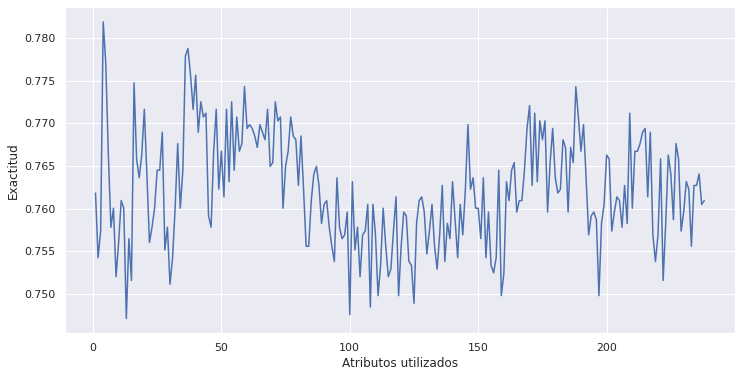

In [87]:
# Grafico score vs cantidad de atributos
n_features_limit = len(X.columns)
features_vec = np.arange(n_features_limit)+1
scores_vec = []
for n_features in range(n_features_limit):
    
    indices = mi_scores_new.argsort()[-n_features:][::-1]
    mi_score_selected_index = mi_scores_new[indices]
    X_1 = X.iloc[:,indices]

    X_train,X_test,y_train,y_test = TTS(X_1,y,random_state=0,stratify=y)

    model = DTC().fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores_vec.append(score)

# Grafico el score en función de la cantidad de atributos utilizados
sns.set()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=features_vec, y=scores_vec)

ax.set(xlabel='Atributos utilizados', ylabel='Exactitud')

plt.show()

Se ve que luego del pico para `n_features = 4`, la exactitud desciende drásticamente y luego oscila a medida que se incrementa la cantidad de atributos del modelo. No se alcanza un pico similar al de `n_features = 4` aún cuando se incluyen todos los atributos del dataset, con lo cual se concluye que hay muchos atributos que no aportan información e incluso confunden al clasificador.

La exactitud alcanzada con este método es 0.783

### 2 - Selección de atributos utilizando Sequential Feature Selection

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden', width='max_content'), max=1.0, s…

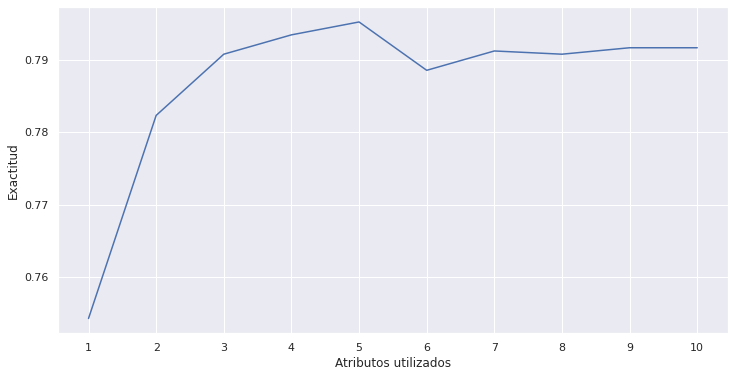

In [169]:
from sklearn.feature_selection import SequentialFeatureSelector
import ipywidgets as widgets

X = X_1
y = df['C3P16.1']

# Grafico exactitud vs cantidad de atributos
n_features_limit = 10
features_vec = np.arange(n_features_limit)+1
scores_vec = []

progress_bar = widgets.FloatProgress(
        value=0,
        min=0,
        max=1,
        bar_style='info',
        style={'bar_color': 'green'},
        orientation='horizontal',
        layout=widgets.Layout(width='max_content',
                                visibility = 'hidden')
    )
display(progress_bar)
progress_bar.layout.visibility = 'visible'

for n_features in range(n_features_limit):

    progress_bar.value = (n_features+1)/n_features_limit
    progress_bar.description = str(int(100 * progress_bar.value)) + ' %'

    #Selecciono los atributos
    sfs = SequentialFeatureSelector(DTC(), n_features_to_select=n_features+1)
    sfs.fit(X, y)

    #Entreno el modelo con los atributos seleccionados
    X_t = sfs.transform(X)
    X_train,X_test,y_train,y_test = TTS(X_t,y,random_state=0,stratify=y)
    model = DTC().fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores_vec.append(score)

progress_bar.layout.visibility = 'hidden'

# Grafico la exactitud en función de la cantidad de atributos utilizados
sns.set()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=features_vec, y=scores_vec)
ax.set_xticks(features_vec)
ax.set(xlabel='Atributos utilizados', ylabel='Exactitud')
plt.show()

In [216]:
print('La máxima exactitud es de:', '%.3f' % scores_vec[4])

La máxima exactitud es de: 0.791


* En este caso mejora un poco la exactitud respecto al método anterior, y el pico se da con 5 atributos en lugar de 4

In [220]:
print('Los atributos seleccionados son:', sfs.get_feature_names_out()[:5])

Los atributos seleccionados son: ['ocupa_cno' 'C2P8.2' 'C1P3.3.4' 'C1P3.3.8' 'antigestab_sd']


Vuelven a aparecer `ocupa_cno` y `C2P8.2` entre los atributos seleccionados.
A continuación las descripciones del conjunto:
* `ocupa_cno`: Ocupación según el Clasificador Nacional de Ocupaciones. Verión 2017 
* `C2P8.2`: Sexo mayoriatario de las personas que integran el ambiente de trabajo con el mismo cargo que la persona encuestada
* `C1P3.3.4`: En su ocupación, realiza principalmente tareas...
* `C1P3.3.8`: A usted lo contrata...
* `C1P3.3.16.6`: Trabajadores que prestan servicio doméstico en casas particulares: antigüedad en el establecimiento -casa- (ocupación principal)

Nota: En este caso no realizo el barrido para todas las cantidades de atributos ya que este método es significativamente más lento que el anterior

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden', width='max_content'), max=1.0, s…

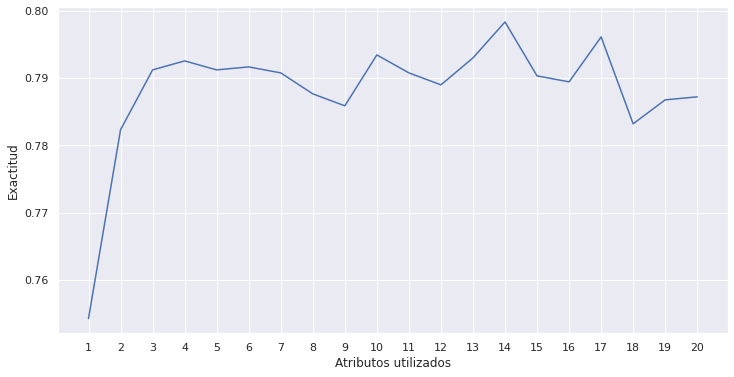

In [212]:
from sklearn.feature_selection import SequentialFeatureSelector
import ipywidgets as widgets

X = X_1
y = df['C3P16.1']

# Grafico exactitud vs cantidad de atributos
n_features_limit = 20
features_vec = np.arange(n_features_limit)+1
scores_vec = []

progress_bar = widgets.FloatProgress(
        value=0,
        min=0,
        max=1,
        bar_style='info',
        style={'bar_color': 'green'},
        orientation='horizontal',
        layout=widgets.Layout(width='max_content',
                                visibility = 'hidden')
    )
display(progress_bar)
progress_bar.layout.visibility = 'visible'

for n_features in range(n_features_limit):

    progress_bar.value = (n_features+1)/n_features_limit
    progress_bar.description = str(int(100 * progress_bar.value)) + ' %'

    #Selecciono los atributos
    sfs = SequentialFeatureSelector(DTC(), n_features_to_select=n_features+1)
    sfs.fit(X, y)
    
    #Entreno el modelo con los atributos seleccionados
    X_t = sfs.transform(X)
    X_train,X_test,y_train,y_test = TTS(X_t,y,random_state=0,stratify=y)
    model = DTC().fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores_vec.append(score)

progress_bar.layout.visibility = 'hidden'

# Grafico la exactitud en función de la cantidad de atributos utilizados
sns.set()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=features_vec, y=scores_vec)
ax.set_xticks(features_vec)

ax.set(xlabel='Atributos utilizados', ylabel='Exactitud')

plt.show()

In [217]:
print('La máxima exactitud es de:', '%.3f' % scores_vec[13])

La máxima exactitud es de: 0.798


Al hacer un barrido hasta 20 atributos la exactitud tuvo una mejora marginal. Por otro lado el tiempo consumido en la selección de los atributos creció significativamente (~40 minutos en comparación de los ~8 usados para barrer hasta 10 atributos), con lo cual aumentar aún más el rango de atributos no parece una opción viable.